## Predictor pLDDT, ipTM para Alphafold

### 0 . Obtención de datos

In [1]:
from data.scripts.preprocessing import process
import os

process(os.path.join(os.getcwd(),'data','traning_alphafold_predictor'))

Buscando archivos en: c:\Users\balde\Desktop\MAESTRIA MNA\PI\drug-design-diabetes-team29\data\traning_alphafold_predictor

Se encontraron 8 archivos. Procesando...
  [OK] Procesado: mpnn_results(1).csv con 560 registros
  [OK] Procesado: mpnn_results(2).csv con 560 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros

Total de registros: 1840

¡ÉXITO! Se ha creado el archivo consolidado en:
c:\Users\balde\Desktop\MAESTRIA MNA\PI\drug-design-diabetes-team29\data\traning_alphafold_predictor\train.csv
Total de filas consolidadas: 1840


### 1. Configuración del Tokenizador y Modelo 

In [2]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from transformers import AutoTokenizer, AutoModel

torch.manual_seed(42)

In [3]:
#Cargamos modelo y tokenizador
MODEL_NAME = "facebook/esm2_t33_650M_UR50D"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [5]:
model = AutoModel.from_pretrained(MODEL_NAME) #Descarga el modelo por primera vez
model.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 1280, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-32): 33 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=1280, out_features=1280, bias=True)
            (key): Linear(in_features=1280, out_features=1280, bias=True)
            (value): Linear(in_features=1280, out_features=1280, bias=True)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=1280, out_features=1280, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=1280, out_features=5120, bias=True)
        )
        (output): EsmOut

### 2. Análisis de datos

In [6]:
df = pd.read_csv("data/traning_alphafold_predictor/train.csv")
df.head()

,plddt,i_ptm,seq
0,0.262914,0.156545,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...
1,0.392581,0.493991,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...
2,0.288697,0.326205,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...
3,0.453222,0.579009,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...
4,0.279486,0.337905,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...


In [7]:
df.shape

(1840, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   plddt   1840 non-null   float64
 1   i_ptm   1840 non-null   float64
 2   seq     1840 non-null   object 
dtypes: float64(2), object(1)
memory usage: 43.2+ KB


In [9]:
df.describe()

,plddt,i_ptm
count,1840.000000,1840.000000
mean,0.407864,0.211371
std,0.110191,0.140819
min,0.213786,0.013096
25%,0.298419,0.078979
50%,0.415183,0.185770
75%,0.509014,0.329365
max,0.680502,0.666694


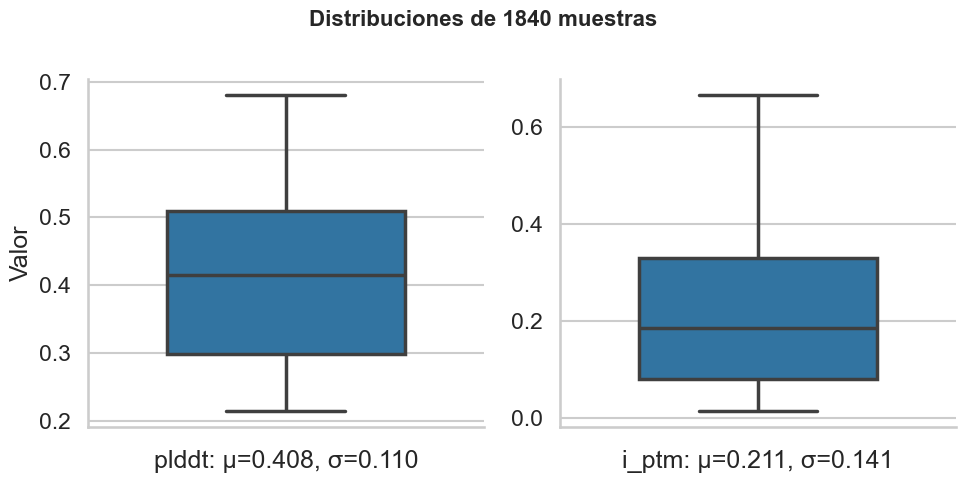

In [10]:
%matplotlib inline
# Calcula estadísticas
stats_text_plddt = f'plddt: μ={df["plddt"].mean():.3f}, σ={df["plddt"].std():.3f}'
stats_text_iptm  = f'i_ptm: μ={df["i_ptm"].mean():.3f}, σ={df["i_ptm"].std():.3f}'
num_muestras = df.shape[0]
#Estilos de gráfica
sns.set_style("whitegrid")
sns.set_context("talk")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f'Distribuciones de {num_muestras} muestras', fontsize=16, fontweight='bold')
sns.boxplot(data=df,y="plddt",ax = axes[0],linewidth=2.5,width=0.6)
axes[0].set_xlabel(stats_text_plddt)
axes[0].set_ylabel('Valor')
sns.boxplot(data=df,y="i_ptm",ax = axes[1],linewidth=2.5,width=0.6)
axes[1].set_xlabel(stats_text_iptm)
axes[1].set_ylabel('')
sns.despine()
plt.tight_layout()


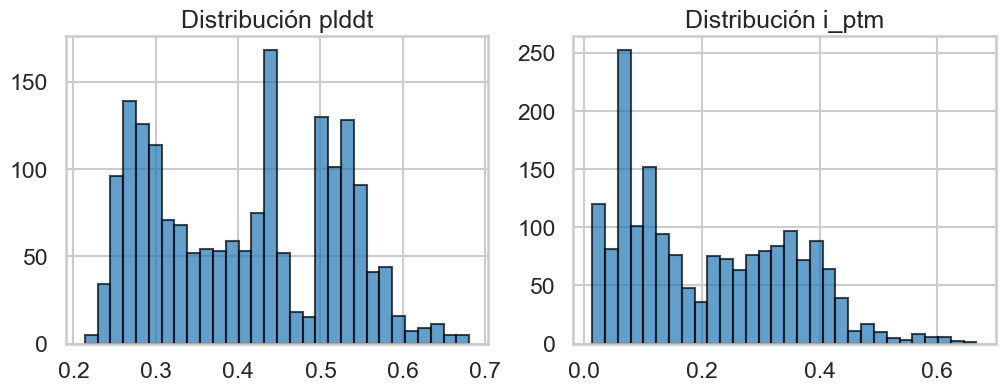

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['plddt'], bins=30, alpha=0.7,edgecolor='black')
axes[0].set_title('Distribución plddt')
axes[1].hist(df['i_ptm'], bins=30,alpha=0.7,edgecolor='black')
axes[1].set_title('Distribución i_ptm')
plt.show()

In [12]:
# Crear tabla con estadísticas
stats_data = {
    'Variable': ['plddt', 'i_ptm'],
    'Media (μ)': [df['plddt'].mean(), df['i_ptm'].mean()],
    'Desv. Est (σ)': [df['plddt'].std(), df['i_ptm'].std()],
    'Asimetría': [stats.skew(df['plddt']), stats.skew(df['i_ptm'])],
    'Curtosis': [stats.kurtosis(df['plddt']), stats.kurtosis(df['i_ptm'])]
}

stats_df = pd.DataFrame(stats_data)

# Redondear valores
stats_df = stats_df.round(3)

print(stats_df)


  Variable  Media (μ)  Desv. Est (σ)  Asimetría  Curtosis
0    plddt      0.408          0.110      0.113    -1.226
1    i_ptm      0.211          0.141      0.455    -0.793


### 3. Feature Engineering

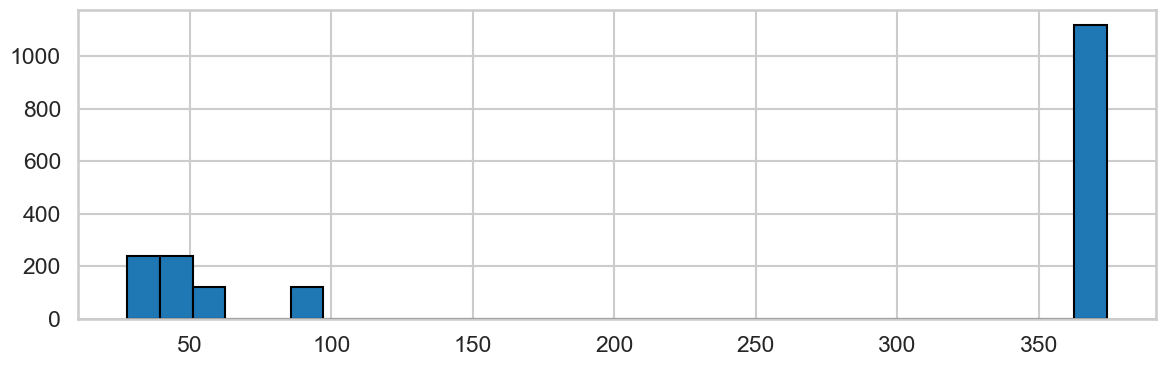

In [13]:
%matplotlib inline
df['seq_length'] = df['seq'].apply(len)
plt.figure(figsize=(12, 4))
# Histograma de longitudes
plt.hist(df['seq_length'], bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Longitud vs plddt')

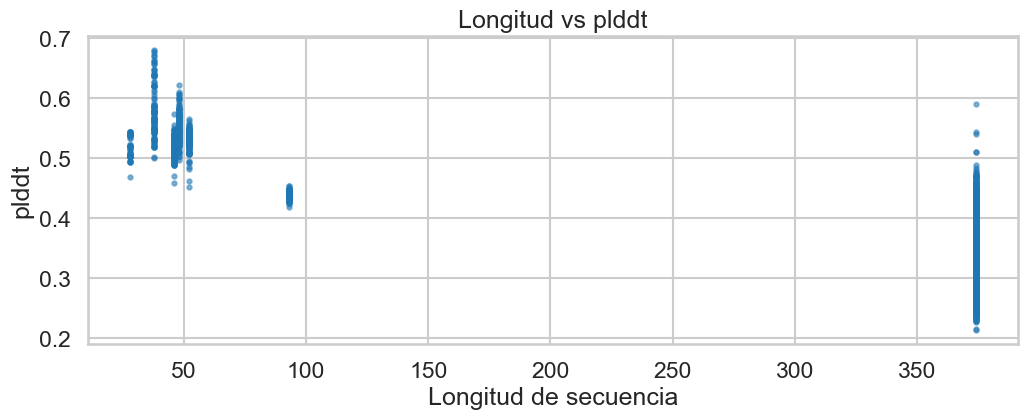

In [14]:
plt.figure(figsize=(12, 4))
plt.scatter(df['seq_length'], df['plddt'], alpha=0.5, s=10)
plt.xlabel('Longitud de secuencia')
plt.ylabel('plddt')
plt.title('Longitud vs plddt')

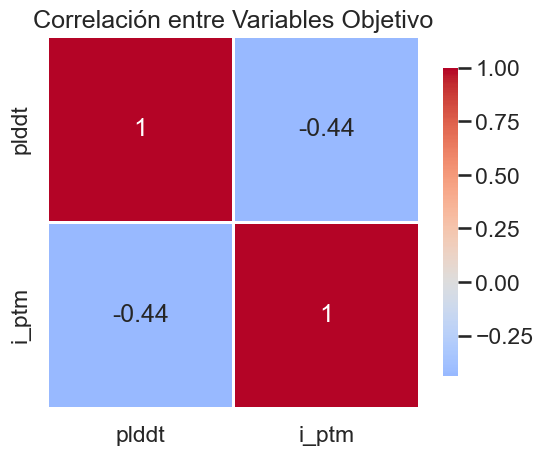

In [15]:
correlation = df[['plddt', 'i_ptm']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlación entre Variables Objetivo')
plt.show()

### 4. Procesamiento con Dataloader

In [16]:

from models.custom_dataloader import CustomProteinDataset
from torch.utils.data import DataLoader, random_split

#Creamos CustomDataset
CSV_PATH = "data/traning_alphafold_predictor/train.csv"
dataset =CustomProteinDataset(CSV_PATH)

#Train/Val Split
total_size = len(dataset)
train_size = int(total_size * 0.8)  # 80% para entrenamiento
val_size = total_size - train_size  # 20% para validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Dataloaders con Batch size
BATCH_SIZE = 16
data_loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_loader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Registros de entrenamiento: {len(train_dataset)}")
print(f"Registros de validación: {len(val_dataset)}")

Registros de entrenamiento: 1472
Registros de validación: 368


### 3. Tokenizador

In [17]:
next(iter(data_loader_train))

[('VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDGEPGSFVNVSCPWYLPWASSVPQGHVYRFCTAEGLWLQKDNSSLPWRDLSECEEEQLLFLYIIYTVGYALSFSALVIASAILLGFRHLHCTRNYIHLNLFASFILRALSVFIKDAALKWMYSTAAQQHQWDGLLSYQDSLSCRLVFLLMQYCVAANYYWLLVEGVYLYTLLAFSVFSEQWIFRLYVSIGWGVPLLFVVPWGIVKYLYEDEGCWTRNSNMNYWLIIRLPILFAIGVNFLIFVRVICIVVSKLKIKCRLAKSTLTLIPLLGTHEVIFAFVMDEHARGTLRFIKLFTELSFTSFQGLMVAIDAVEELFRWLSRLLELKALQ',
  'EQWIFRLYVSIGWGVPLLFVVPWGIVKYLYEDEGCWTRNSNMNYWLIIRLPILFAIGVNFLIFVRVICIVVSKLKSLLLIILLGIITALLLL',
  'VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDGEPGSFVNVSCPWYLPWASSVPQGHVYRFCTAEGLWLQKDNSSLPWRDLSECEEEQLLFLYIIYTVGYALSFSALVIASAILLGFRHLHCTRNYIHLNLFASFILRALSVFIKDAALKWMYSTAAQQHQWDGLLSYQDSLSCRLVFLLMQYCVAANYYWLLVEGVYLYTLLAFSVFSEQWIFRLYVSIGWGVPLLFVVPWGIVKYLYEDEGCWTRNSNMNYWLIIRLPILFAIGVNFLIFVRVICIVVSKLKIKCRLAKSTLTLIPLLGTHEVIFAFVMDEHARGTLRFIKLFTELSFTSFQGLMVAIDAEEELFRELAELLERQALS',
  'EQLLFLYIIYTVGYALSFSALVIASAILLGEQLLILLLILLLLLA',
  'VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDGEPGSFVNVSCPWYLPWASSVPQGHVYRFCTAEGLWLQKDNSSLP

In [19]:

inputs = tokenizer(
    next(iter(data_loader_train))[0], 
    padding=True, #Padding para el mismo tamaño
    truncation=True, #Recorta en caso de que sean muy largas
    return_tensors="pt" #Regresa tensores de pytorch
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [20]:
inputs['input_ids'].shape

torch.Size([16, 375])

In [21]:
with torch.no_grad():
    # Pasamos los tensores tokenizados al modelo
    outputs = model(**inputs)

In [22]:
#Luego de pasar por la última capa tenemos  [num_secuencias, longitud_max_secuencia, dimension_emb]
outputs.last_hidden_state.shape 

torch.Size([16, 375, 1280])

In [23]:
embedding_por_residuo = outputs.last_hidden_state
embedding_por_secuencia = embedding_por_residuo.mean(dim=1) #Promedio por cada secuencia

In [24]:
embedding_por_secuencia.shape

torch.Size([16, 1280])

# Alternativas usando Deep Learniing

In [26]:
from models.mlp import MLP_pLDDT
import torch.nn as nn
import torch.optim as optim

input_size = 1280
hidden_sizes = [512]  # 1 capas ocultas
output_size = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model_mlp = MLP_pLDDT(input_size, hidden_sizes, output_size).to(device)
print(model_mlp)

criterion = nn.MSELoss()  # Mean Squared Error para regresión
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

MLP_pLDDT(
  (network): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [28]:
#MODELO DE MULTILAYER PERCEPTRON

# Early Stopping variables
EPOCHS = 100
paciencia = 10        # Épocas a esperar después de la última mejora
epochs_sin_mejora = 0 # Contador
best_val_loss = np.inf  # Inicia con infinito para que cualquier pérdida sea mejor
ruta_mejor_modelo = 'models/best_model_mlp.pth' # Dónde guardar el mejor modelo
# ----------------------------------------

mlp_train_losses = []
mlp_val_losses = []
for epoch in range(EPOCHS):
    #TRAINING
    model_mlp.train()
    total_epoch_loss = 0.0
    for i , (sequences_batch, plddts_batch,_) in enumerate(data_loader_train):
        plddts_batch = plddts_batch.to(device)
        inputs = tokenizer(sequences_batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        embeddings_batch = outputs.last_hidden_state.mean(dim=1)
        predictions = model_mlp(embeddings_batch)
        loss = criterion(predictions, plddts_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(data_loader_train)
    mlp_train_losses.append(avg_epoch_loss)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA")
    print(f"Pérdida Promedio de la Época: {avg_epoch_loss:.4f}")

    #VALIDATION
    model_mlp.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for i , (sequences_batch, plddts_batch,_) in enumerate(data_loader_val):
            plddts_batch = plddts_batch.to(device)
            inputs = tokenizer(sequences_batch, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            
            embeddings_batch = outputs.last_hidden_state.mean(dim=1)
            predictions = model_mlp(embeddings_batch)
            loss = criterion(predictions, plddts_batch)

            total_val_loss += loss.item()

    avg_epoch_loss_val = total_val_loss / len(data_loader_val)
    mlp_val_losses.append(avg_epoch_loss_val)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA VAL")
    print(f"Pérdida Promedio de la Época VAL: {avg_epoch_loss_val:.4f}")

    #Early Stopping Lógica
    if avg_epoch_loss_val < best_val_loss:
        # ¡Mejora!
        best_val_loss = avg_epoch_loss_val
        epochs_sin_mejora = 0
        
        # Guardamos los pesos del mejor modelo
        torch.save(model_mlp.state_dict(), ruta_mejor_modelo)
        print("¡Mejora detectada! Guardando modelo...")
    
    else:
        # No hubo mejora
        epochs_sin_mejora += 1
        print(f"Sin mejora. Contador: {epochs_sin_mejora}/{paciencia}")

    # Comprobamos si hemos superado la paciencia
    if epochs_sin_mejora >= paciencia:
        print(f"\n¡Parada temprana! No hubo mejora en {paciencia} épocas.")
        break  # Rompemos el bucle de entrenamiento




ÉPOCA 1 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0036
ÉPOCA 1 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0026
¡Mejora detectada! Guardando modelo...
ÉPOCA 2 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0028
ÉPOCA 2 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0025
¡Mejora detectada! Guardando modelo...
ÉPOCA 3 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0027
ÉPOCA 3 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0021
¡Mejora detectada! Guardando modelo...
ÉPOCA 4 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0024
ÉPOCA 4 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0020
¡Mejora detectada! Guardando modelo...
ÉPOCA 5 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0024
ÉPOCA 5 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0020
¡Mejora detectada! Guardando modelo...
ÉPOCA 6 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0023
ÉPOCA 6 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0020
Sin mejora. C

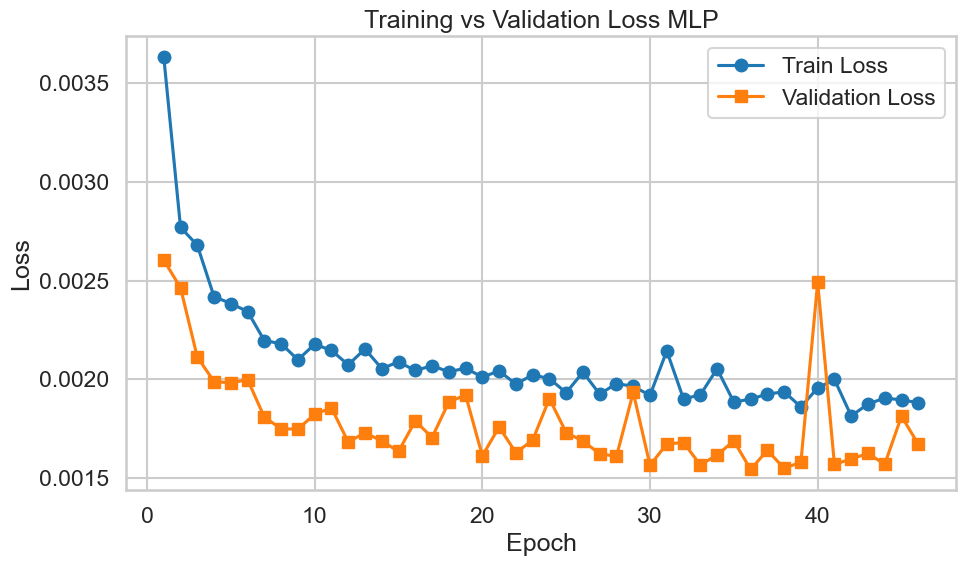

In [38]:
plt.figure(figsize=(10, 6))
epochs_used = range(1, len(mlp_train_losses)+ 1)
plt.plot(epochs_used, mlp_train_losses, label='Train Loss', marker='o')
plt.plot(epochs_used, mlp_val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss MLP')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(save_path, dpi=300)
plt.show()

In [ ]:
#Guardamos modelo 
#torch.save(model_mlp.state_dict(), 'mlp_weights.pth')

In [18]:
#MODELO DE CONVOLUCIÓN 1 DIMENSIÓN
from models.conv1d_protein import Simple1CNN
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model_cnn = Simple1CNN().to(device)
print(model_cnn)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Early Stopping variables
EPOCHS = 100
paciencia = 7
epochs_sin_mejora = 0
best_val_loss = np.inf
ruta_mejor_modelo = 'models/best_model_cnn.pth'

cnn_train_losses = []
cnn_val_losses = []

for epoch in range(EPOCHS):
    #TRAIN
    total_epoch_loss = 0.0
    model_cnn.train()
    for i , (sequences_batch, plddts_batch, _) in enumerate(data_loader_train):
        plddts_batch = plddts_batch.to(device)
        inputs = tokenizer(sequences_batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        embeddings_batch = outputs.last_hidden_state #Diferencia con el método anterior
        predictions = model_cnn(embeddings_batch)
        loss = criterion(predictions, plddts_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(data_loader_train)
    cnn_train_losses.append(avg_epoch_loss)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA")
    print(f"Pérdida Promedio de la Época: {avg_epoch_loss:.4f}")

    #VALIDATION
    model_cnn.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for i , (sequences_batch, plddts_batch, _) in enumerate(data_loader_val):
            plddts_batch = plddts_batch.to(device)
            inputs = tokenizer(sequences_batch, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            
            embeddings_batch = outputs.last_hidden_state #Difiere por naturaleza de Convolución, no hacemos promedio
            predictions = model_cnn(embeddings_batch)
            loss = criterion(predictions, plddts_batch)

            total_val_loss += loss.item()

    avg_epoch_loss_val = total_val_loss / len(data_loader_val)
    cnn_val_losses.append(avg_epoch_loss_val)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA VAL")
    print(f"Pérdida Promedio de la Época VAL: {avg_epoch_loss_val:.4f}")

    #Early Stopping Lógica
    if avg_epoch_loss_val < best_val_loss:
        # ¡Mejora!
        best_val_loss = avg_epoch_loss_val
        epochs_sin_mejora = 0
        
        # Guardamos los pesos del mejor modelo
        torch.save(model_cnn.state_dict(), ruta_mejor_modelo)
        print("¡Mejora detectada! Guardando modelo...")
    
    else:
        # No hubo mejora
        epochs_sin_mejora += 1
        print(f"Sin mejora. Contador: {epochs_sin_mejora}/{paciencia}")

    # Comprobamos si hemos superado la paciencia
    if epochs_sin_mejora >= paciencia:
        print(f"\n¡Parada temprana! No hubo mejora en {paciencia} épocas.")
        break  # Rompemos el bucle de entrenamiento



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Simple1CNN(
  (conv1): Conv1d(1280, 256, kernel_size=(5,), stride=(1,), padding=same)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
ÉPOCA 1 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0197
ÉPOCA 1 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0026
¡Mejora detectada! Guardando modelo...
ÉPOCA 2 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0028
ÉPOCA 2 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0023
¡Mejora detectada! Guardando modelo...
ÉPOCA 3 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0026
ÉPOCA 3 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0021
¡Mejora detectada! Guardando modelo...
ÉPOCA 4 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0024
ÉPOCA 4 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0020
¡Mejora detectada! Guardando modelo...
ÉPOCA 5 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0025
ÉPOCA 5 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0

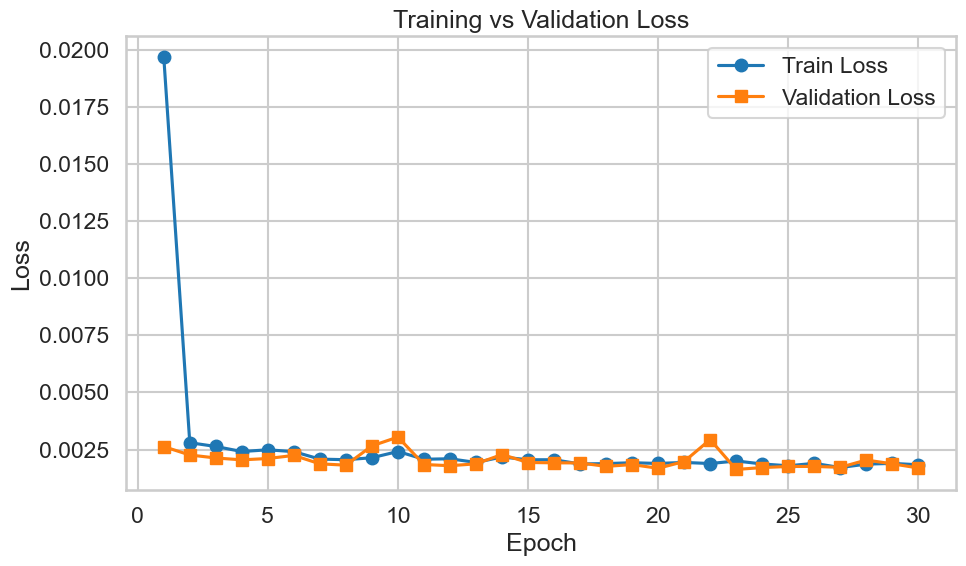

In [ ]:
plt.figure(figsize=(10, 6))
epochs = range(1, len(cnn_train_losses)+ 1)
plt.plot(epochs, cnn_train_losses, label='Train Loss', marker='o')
plt.plot(epochs, cnn_val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss CNN1D')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(save_path, dpi=300)
plt.show()

# Modelo de XGboost y RandomForest de ML clásico

In [18]:
#TRAIN DATA LOADER to numpy array
train_data = []
train_targets = []
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

for data, target, target2,_,_ in train_dataset:
    target = target.to(device)
    inputs = tokenizer(data, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding_por_residuo = outputs.last_hidden_state
        embedding_por_secuencia = embedding_por_residuo.mean(dim=1) 
    train_targets.append(target.cpu().numpy()[0])
    train_data.append(embedding_por_secuencia.cpu().numpy()[0])

train_data_np = np.array(train_data)
train_targets_np = np.array(train_targets)


#VAL DATA LOADER to numpy array
val_data = []
val_targets = []

for data, target, target2,_,_ in val_dataset:
    target = target.to(device)
    inputs = tokenizer(data, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding_por_residuo = outputs.last_hidden_state
        embedding_por_secuencia = embedding_por_residuo.mean(dim=1) 
    val_targets.append(target.cpu().numpy()[0])
    val_data.append(embedding_por_secuencia.cpu().numpy()[0])
    
val_data_np = np.array(val_data)
val_targets_np = np.array(val_targets)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [19]:
train_data_np.shape, train_targets_np.shape , val_data_np.shape, val_targets_np.shape

((1472, 1280), (1472,), (368, 1280), (368,))

In [20]:
#Entrenamos un RandomForestRegressor para ver como desempeñaría

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(train_data_np, train_targets_np)

print("Evaluando en el conjunto de train")
y_pred_train = random_forest.predict(train_data_np)

mse = mean_squared_error(train_targets_np, y_pred_train)
print(f"\nError Cuadrático Medio (MSE) en train: {mse:.6f}")

print("Evaluando en el conjunto de val")
y_pred_val = random_forest.predict(val_data_np)

mse = mean_squared_error(val_targets_np, y_pred_val)
print(f"\nError Cuadrático Medio (MSE) en val: {mse:.6f}")

Evaluando en el conjunto de train

Error Cuadrático Medio (MSE) en train: 0.000182
Evaluando en el conjunto de val

Error Cuadrático Medio (MSE) en val: 0.001230


Entrenando modelo Gradient Boosting...
R2 en training: 0.9873900288574028
R2 en val: 0.8949467614204205
¡Cálculo de pérdidas completado!


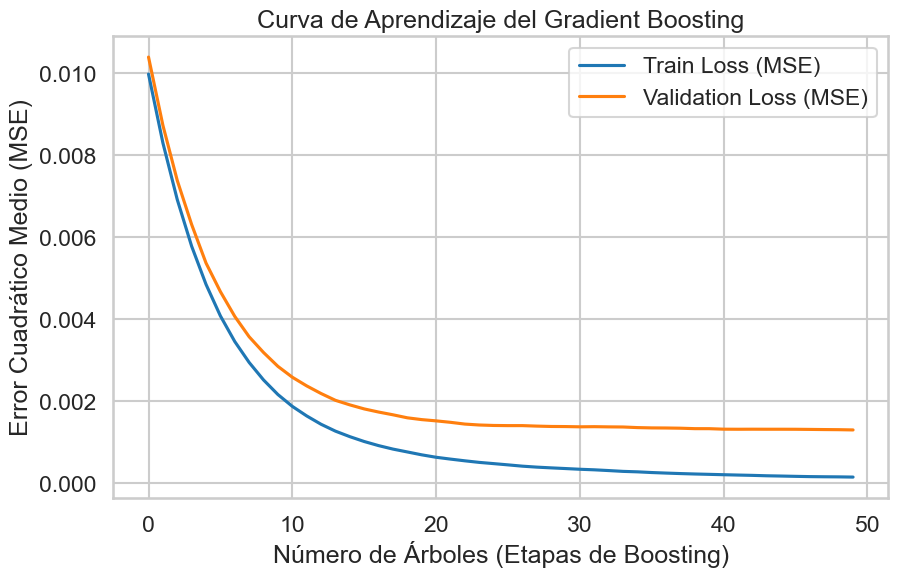

In [21]:
%matplotlib inline
#Entrenamos un GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

model_gbm = GradientBoostingRegressor(n_estimators=50, random_state=42,max_depth=5)

print("Entrenando modelo Gradient Boosting...")
model_gbm.fit(train_data_np, train_targets_np)

# Calcula el MSE en el conjunto de entrenamiento en cada etapa
train_preds_staged = model_gbm.staged_predict(train_data_np)
preds_r2 = model_gbm.predict(train_data_np)
r2_train = r2_score(train_targets_np, preds_r2)
print(f"R2 en training: {r2_train}")
train_losses = [mean_squared_error(train_targets_np, preds) for preds in train_preds_staged]

# Calcula el MSE en el conjunto de validación en cada etapa
test_preds_staged = model_gbm.staged_predict(val_data_np)
preds_r2 = model_gbm.predict(val_data_np)
r2_val = r2_score(val_targets_np, preds_r2)
print(f"R2 en val: {r2_val}")  
test_losses = [mean_squared_error(val_targets_np, preds) for preds in test_preds_staged]

print("¡Cálculo de pérdidas completado!")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss (MSE)")
plt.plot(test_losses, label="Validation Loss (MSE)")
plt.xlabel("Número de Árboles (Etapas de Boosting)")
plt.ylabel("Error Cuadrático Medio (MSE)")
plt.title("Curva de Aprendizaje del Gradient Boosting")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#Guardamos mejor modelo de ml clásico
import joblib
joblib.dump(model_gbm, 'models/best_model_plddt_vf.joblib')

['models/best_model_plddt_vf.joblib']

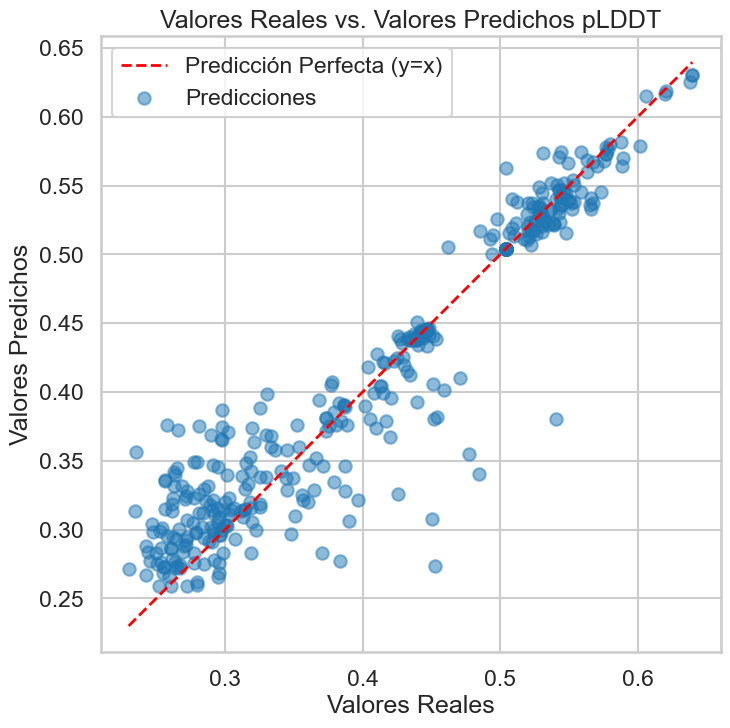

In [23]:
#Comparamos predicciones con valores reales en val con un scatterplot
plt.figure(figsize=(8, 8))
preds =model_gbm.predict(val_data_np)
min_val = min(np.min(val_targets_np), np.min(preds))
max_val = max(np.max(val_targets_np), np.max(preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta (y=x)')
plt.scatter(val_targets_np, preds, alpha=0.5, label='Predicciones')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Valores Reales vs. Valores Predichos pLDDT")
plt.legend()
plt.grid(True)
plt.axis('equal') # Asegura que la escala de X e Y sea la misma 
plt.show()

Entrenando modelo XGBoost...
¡Entrenamiento completado!
------------------------------
Métricas Finales (última etapa):
Error Cuadrático Medio Raíz(RMSE) en train: 0.0009
Error Cuadrático Medio Raiz(RMSE) en val:   0.0359
------------------------------


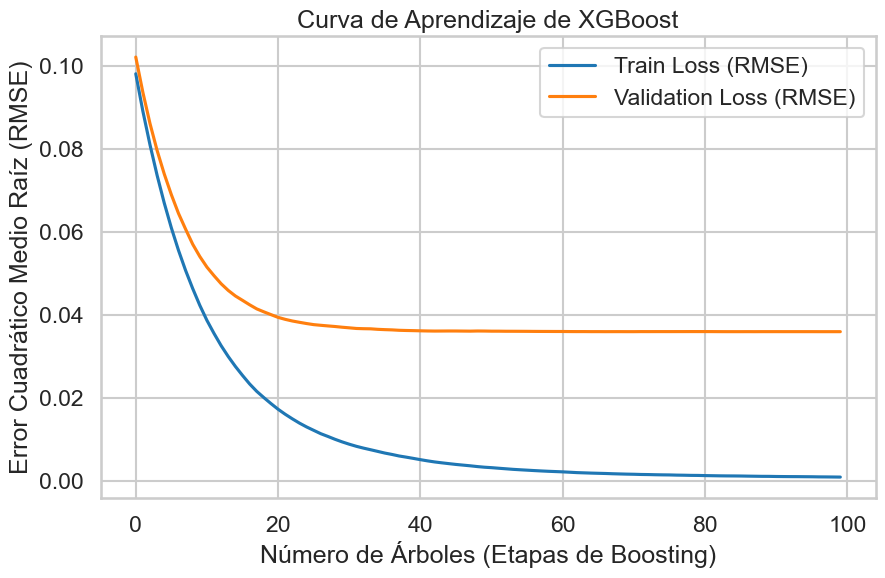

In [25]:
#Modelo de XGBOOST 
import xgboost as xgb

eval_set = [
    (train_data_np, train_targets_np),  # Etiquetado como 'validation_0'
    (val_data_np, val_targets_np)     # Etiquetado como 'validation_1'
]

model_xgb = xgb.XGBRegressor(n_estimators=100,random_state=42,max_depth=8,learning_rate=0.1,eval_metric="rmse")


print("Entrenando modelo XGBoost...")

model_xgb.fit(
    train_data_np, train_targets_np,
    eval_set=eval_set,   # Los datos para monitorear
    verbose=False        # Para no imprimir el log de cada etapa
)

print("¡Entrenamiento completado!")

results = model_xgb.evals_result()

train_losses = results['validation_0']['rmse']
test_losses = results['validation_1']['rmse']

#Imprime las métricas finales
print("-" * 30)
print("Métricas Finales (última etapa):")
print(f"Error Cuadrático Medio Raíz(RMSE) en train: {train_losses[-1]:.4f}")
print(f"Error Cuadrático Medio Raiz(RMSE) en val:   {test_losses[-1]:.4f}")
print("-" * 30)

#Graficamos
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss (RMSE)")
plt.plot(test_losses, label="Validation Loss (RMSE)")
plt.xlabel("Número de Árboles (Etapas de Boosting)")
plt.ylabel("Error Cuadrático Medio Raíz (RMSE)")
plt.title("Curva de Aprendizaje de XGBoost")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Modelo Regularizado Lineal,sólo por el bien de revisar un modelo lineal
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data_np)
X_test_scaled = scaler.transform(val_data_np)

model_ridge = Ridge(alpha=1.0) 
model_ridge.fit(X_train_scaled, train_targets_np)

y_pred = model_ridge.predict(X_train_scaled)
mse = mean_squared_error(train_targets_np, y_pred)
print(f"MSE del Modelo Ridge Train: {mse:.5f}")

y_pred = model_ridge.predict(X_test_scaled)
mse = mean_squared_error(val_targets_np, y_pred)
print(f"MSE del Modelo Ridge Val: {mse:.5f}")

MSE del Modelo Ridge Train: 0.00123
MSE del Modelo Ridge Val: 0.00244


['models/best_model_plddt.joblib']

# Predictor para ipTM de Alphafold

## Arquitectura Siamesa usando Deep Learning

In [17]:
#Modelo de Red Siamesa
from models.siamese_network import SiameseNetwork
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu" 
model = model.to(device)
model_snn = SiameseNetwork(embedding_dim=1280, hidden_dim=256,encoding_dim=64).to(device)
print(model_snn)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_snn.parameters(), lr=0.0001)

SiameseNetwork(
  (siamese_tower): Sequential(
    (0): Linear(in_features=1280, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
  )
  (regression_head): Sequential(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
#Vemos ahora que para este modelo tiene estructura de:
#SECUENCIA COMPLETA , PLDDT_SCORE, IPTM_SCORE , SECA , SECB
#DONDE SECUENCIA COMPLETA = SECA+SECB
next(iter(data_loader_train))

('SSEELLFRLLDRLLELKALA',
 'FDEVLAKLLEELAQS',
 'EQLLILLLIVLLLLG',
 'FDELFEEILEELANS',
 'VWLPALLLGLILLLIELLR',
 'SLLLIILLGIITALLLL',
 'DAVEELFRELSRLLELKALQ',
 'VNPVALLVLLVLLLLALLE',
 'PNLVALLIGILLAFLALLR',
 'SSTEELFRELSRLLELKALQ',
 'VWPVALLLLLVLLLLELLR',
 'SSTEELFRLLAEQLELEALS',
 'SYEPEILRGFLALYLAEAQR',
 'AFEPEVLAGFLALYLAEAAK',
 'MSEEELFRELARLLEEKALS',
 'SYDLEVERGFVALYLAEAQR')

In [18]:
#MODELO DE RED SIAMESA
# Early Stopping variables
EPOCHS = 100
paciencia = 5
epochs_sin_mejora = 0 
best_val_loss = np.inf  
ruta_mejor_modelo = 'models/best_model_snn_vf.pth'
# ----------------------------------------

snn_train_losses = []
snn_val_losses = []
for epoch in range(EPOCHS):
    #TRAINING
    model_snn.train()
    total_epoch_loss = 0.0
    for i , (_, _ , iptms_batch, seq1_batch, seq2_batch) in enumerate(data_loader_train):
        iptms_batch = iptms_batch.to(device)
        inputs1 = tokenizer(seq1_batch, padding=True, truncation=True, return_tensors="pt").to(device)
        inputs2 = tokenizer(seq2_batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs1 = model(**inputs1)
            outputs2 = model(**inputs2)

        embeddings_batch1 = outputs1.last_hidden_state.mean(dim=1)
        embeddings_batch2 = outputs2.last_hidden_state.mean(dim=1)
        predictions = model_snn(embeddings_batch1, embeddings_batch2)
        loss = criterion(predictions, iptms_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(data_loader_train)
    snn_train_losses.append(avg_epoch_loss)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA")
    print(f"Pérdida Promedio de la Época: {avg_epoch_loss:.4f}")

    #VALIDATION
    model_snn.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for i , (_, _ , iptms_batch, seq1_batch, seq2_batch) in enumerate(data_loader_val):
            iptms_batch = iptms_batch.to(device)
            inputs1 = tokenizer(seq1_batch, padding=True, truncation=True, return_tensors="pt").to(device)
            inputs2 = tokenizer(seq2_batch, padding=True, truncation=True, return_tensors="pt").to(device)

            outputs1 = model(**inputs1)
            outputs2 = model(**inputs2)

            embeddings_batch1 = outputs1.last_hidden_state.mean(dim=1)
            embeddings_batch2 = outputs2.last_hidden_state.mean(dim=1)
            predictions = model_snn(embeddings_batch1, embeddings_batch2)
            loss = criterion(predictions, iptms_batch)

            total_val_loss += loss.item()

    avg_epoch_loss_val = total_val_loss / len(data_loader_val)
    snn_val_losses.append(avg_epoch_loss_val)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA VAL")
    print(f"Pérdida Promedio de la Época VAL: {avg_epoch_loss_val:.4f}")

    #Early Stopping Lógica
    if avg_epoch_loss_val < best_val_loss:
        # ¡Mejora!
        best_val_loss = avg_epoch_loss_val
        epochs_sin_mejora = 0
        
        # Guardamos los pesos del mejor modelo
        torch.save(model_snn.state_dict(), ruta_mejor_modelo)
        print("¡Mejora detectada! Guardando modelo...")
    
    else:
        # No hubo mejora
        epochs_sin_mejora += 1
        print(f"Sin mejora. Contador: {epochs_sin_mejora}/{paciencia}")

    # Comprobamos si hemos superado la paciencia
    if epochs_sin_mejora >= paciencia:
        print(f"\n¡Parada temprana! No hubo mejora en {paciencia} épocas.")
        break  # Rompemos el bucle de entrenamiento




Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


ÉPOCA 1 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0289
ÉPOCA 1 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0067
¡Mejora detectada! Guardando modelo...
ÉPOCA 2 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0087
ÉPOCA 2 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0057
¡Mejora detectada! Guardando modelo...
ÉPOCA 3 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0085
ÉPOCA 3 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0057
¡Mejora detectada! Guardando modelo...
ÉPOCA 4 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0078
ÉPOCA 4 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0054
¡Mejora detectada! Guardando modelo...
ÉPOCA 5 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0076
ÉPOCA 5 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0051
¡Mejora detectada! Guardando modelo...
ÉPOCA 6 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0070
ÉPOCA 6 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0049
¡Mejora detec

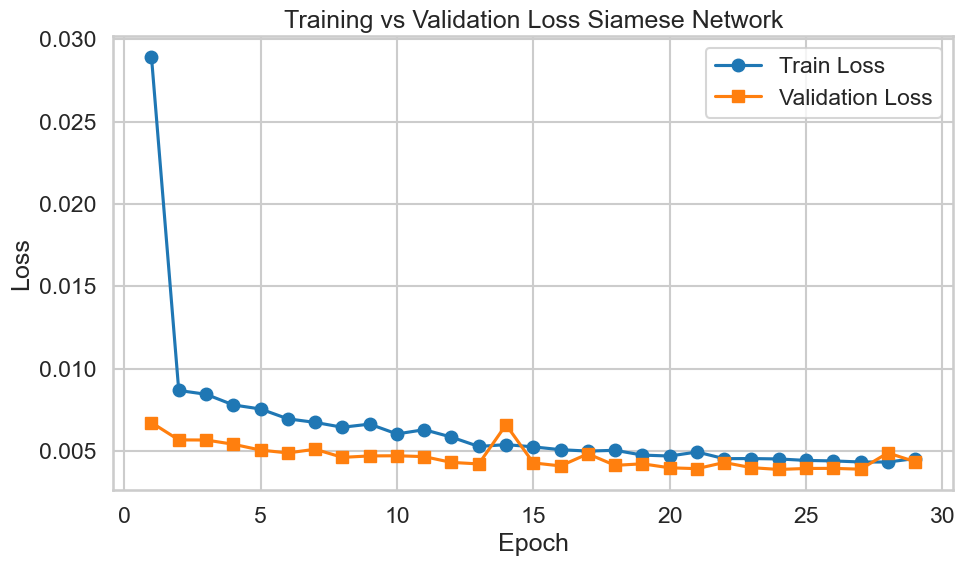

In [20]:
plt.figure(figsize=(10, 6))
epochs = range(1, len(snn_train_losses)+ 1)
plt.plot(epochs, snn_train_losses, label='Train Loss', marker='o')
plt.plot(epochs, snn_val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Siamese Network')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(save_path, dpi=300)
plt.show()

## Modelos de ML clásico

In [19]:
#Creamos CustomDataset de nuevo para los demás modelos de ML clásicos
CSV_PATH = "data/traning_alphafold_predictor/train.csv"
from models.siamese_network import SiameseNetwork
dataset =CustomProteinDataset(CSV_PATH)

#Train/Val Split
total_size = len(dataset)
train_size = int(total_size * 0.8)  # 80% para entrenamiento
val_size = total_size - train_size  # 20% para validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Dataloaders con Batch size
BATCH_SIZE = 16
#Aqui como estamos usando los features aprendidos del Siamese NN no es necesario el shuffle
data_loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
data_loader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Registros de entrenamiento: {len(train_dataset)}")
print(f"Registros de validación: {len(val_dataset)}")

Registros de entrenamiento: 1568
Registros de validación: 392


In [21]:
def extract_features(model_snn, dataloader, device):
    model_snn.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i , (_, _ , iptms_batch, seq1_batch, seq2_batch) in enumerate(dataloader):
            iptms_batch = iptms_batch.to(device)
            inputs1 = tokenizer(seq1_batch, padding=True, truncation=True, return_tensors="pt").to(device)
            inputs2 = tokenizer(seq2_batch, padding=True, truncation=True, return_tensors="pt").to(device)

            outputs1 = model(**inputs1)
            outputs2 = model(**inputs2)

            embeddings_batch1 = outputs1.last_hidden_state.mean(dim=1)
            embeddings_batch2 = outputs2.last_hidden_state.mean(dim=1)

             # Llamamos directamente a la torre:
            encoding_a = model_snn.siamese_tower(embeddings_batch1)
            encoding_b = model_snn.siamese_tower(embeddings_batch2)
            # ------------------------------------
            
            difference = torch.abs(encoding_a - encoding_b)
            features = torch.cat((encoding_a, encoding_b, difference), dim=1)
            
            all_features.append(features.cpu())
            all_labels.append(iptms_batch.cpu())

    features_tensor = torch.cat(all_features, dim=0)
    labels_tensor = torch.cat(all_labels, dim=0)
    
    # 5. Convertir a NumPy para XGBoost/Scikit-learn
    features_np = features_tensor.numpy()
    labels_np = labels_tensor.numpy().ravel() 
    
    return features_np, labels_np

#Usando los features aprendidos, pasamos directo sin el cabezal regresor
#Ya que de esos features los usaremos para aplicar ML clásico
ruta_mejor_modelo = 'models/best_model_snn_vf.pth'
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

model_snn = SiameseNetwork(embedding_dim=1280, hidden_dim=256,encoding_dim=64).to(device)
model_snn.load_state_dict(torch.load(ruta_mejor_modelo))

C:\Users\balde\AppData\Local\Temp\ipykernel_18020\170531087.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_snn.load_state_dict(torch.load(ruta_mejor_modelo))


<All keys matched successfully>

In [22]:
features_train_np, labels_train_np = extract_features(model_snn,data_loader_train, device)
features_val_np, labels_val_np = extract_features(model_snn,data_loader_val, device)

In [23]:
features_train_np.shape , features_val_np.shape

((1472, 192), (368, 192))

Entrenando modelo XGBoost...
[0]	validation_0-rmse:0.14140	validation_1-rmse:0.13220
[100]	validation_0-rmse:0.06731	validation_1-rmse:0.07239
[200]	validation_0-rmse:0.04265	validation_1-rmse:0.06290
[300]	validation_0-rmse:0.03308	validation_1-rmse:0.06281
[348]	validation_0-rmse:0.03035	validation_1-rmse:0.06315
¡Entrenamiento completado!
------------------------------
Métricas Finales (última etapa):
Error Cuadrático Medio Raíz(RMSE) en train: 0.0303
Error Cuadrático Medio Raiz(RMSE) en val:   0.0632
------------------------------


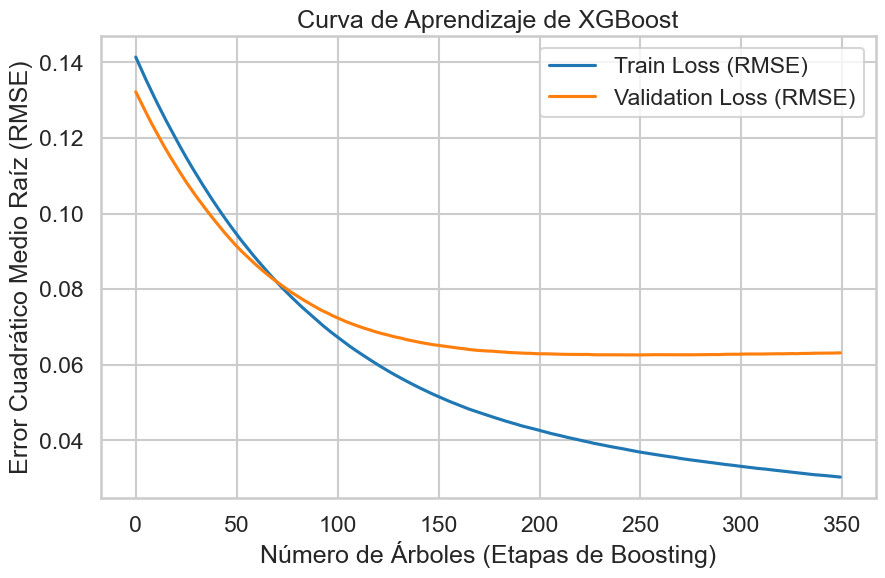

In [24]:
#Modelo de XGBOOST 
import xgboost as xgb

eval_set = [
    (features_train_np, labels_train_np),  # Etiquetado como 'validation_0'
    (features_val_np, labels_val_np)     # Etiquetado como 'validation_1'
]

model_xgb_iptm = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=100
)

print("Entrenando modelo XGBoost...")

model_xgb_iptm.fit(
    features_train_np, labels_train_np,
    eval_set=eval_set, 
    verbose=100
)

print("¡Entrenamiento completado!")

results = model_xgb_iptm.evals_result()

train_losses = results['validation_0']['rmse']
test_losses = results['validation_1']['rmse']

#Imprime las métricas finales
print("-" * 30)
print("Métricas Finales (última etapa):")
print(f"Error Cuadrático Medio Raíz(RMSE) en train: {train_losses[-1]:.4f}")
print(f"Error Cuadrático Medio Raiz(RMSE) en val:   {test_losses[-1]:.4f}")
print("-" * 30)

#Graficamos
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss (RMSE)")
plt.plot(test_losses, label="Validation Loss (RMSE)")
plt.xlabel("Número de Árboles (Etapas de Boosting)")
plt.ylabel("Error Cuadrático Medio Raíz (RMSE)")
plt.title("Curva de Aprendizaje de XGBoost")
plt.legend()
plt.grid(True)
plt.show()

R2 score en val: 0.7795556783676147


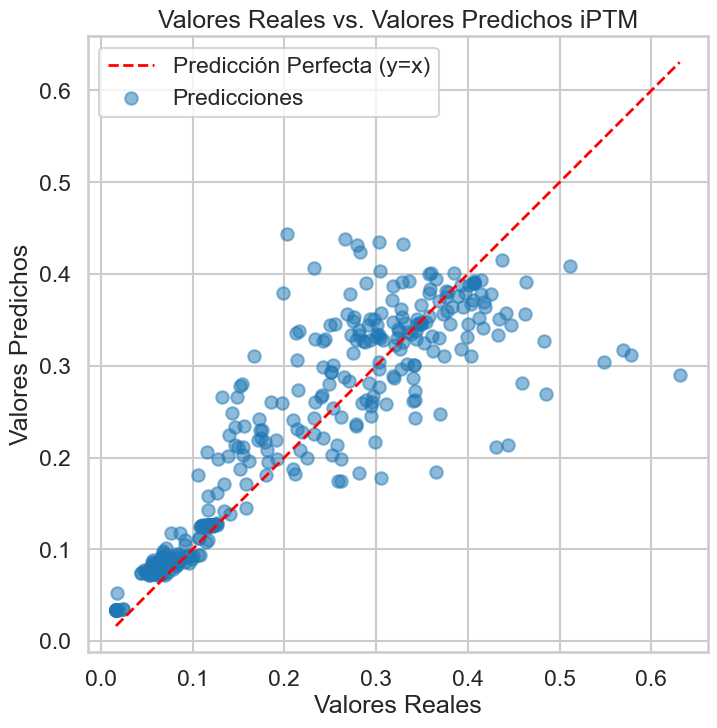

In [25]:
from sklearn.metrics import r2_score

preds = model_xgb_iptm.predict(features_val_np)
r2_score_val = r2_score(labels_val_np,preds)

print(f"R2 score en val: {r2_score_val}")
plt.figure(figsize=(8, 8))
min_val = min(np.min(labels_val_np), np.min(preds))
max_val = max(np.max(labels_val_np), np.max(preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta (y=x)')
plt.scatter(labels_val_np, preds, alpha=0.5, label='Predicciones')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Valores Reales vs. Valores Predichos iPTM")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [26]:
#Entrenamos un RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

random_forest = RandomForestRegressor(
    n_estimators=300,
    n_jobs=-1,
    random_state=42,
    max_depth=15
)
random_forest.fit(features_train_np, labels_train_np)

print("Evaluando en el conjunto de train")
y_pred_train = random_forest.predict(features_train_np)

mse = mean_squared_error(labels_train_np, y_pred_train)
print(f"\nError Cuadrático Medio (MSE) en train: {mse:.6f}")

print("Evaluando en el conjunto de val")
y_pred_val = random_forest.predict(features_val_np)

mse = mean_squared_error(labels_val_np, y_pred_val)
print(f"\nError Cuadrático Medio (MSE) en val: {mse:.6f}")

Evaluando en el conjunto de train

Error Cuadrático Medio (MSE) en train: 0.000518
Evaluando en el conjunto de val

Error Cuadrático Medio (MSE) en val: 0.004121


In [27]:
#Guardamos mejor modelo de xgboost
model_xgb_iptm.save_model("models/mi_modelo_ganador_xgb_vf.json")
print("¡Modelo XGBoost guardado exitosamente como 'mi_modelo_ganador_xgb_vf.json'!")

¡Modelo XGBoost guardado exitosamente como 'mi_modelo_ganador_xgb_vf.json'!
